# Predicting the quality of wine based on its chemical make-up.
### Introduction:
The taste of a wine is affected by its chemical properties/composition (i.e. pH, alcohol content, sugar content, etc.). We wish to predict the quality of a wine given its chemical composition. Although "quality" of wine is a rather abstract and subjective metric, there are trends in the chemical composition of wines which are correlated with its perceived quality. This allows us to predict its quality based on its chemical composition. In order to accomplish this, we are will be using [this data set](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/) based on data collected from Portuguese "Vinho Verde" wine to assess these factors. There are 11 chemical properties of the wine which are recorded in this data set. The measured quality of the wine is a categorical variable labeled 1-10.

Research question: How can wine quality be predicted using its chemical composition?

### Methods & Results
For this project we will be using classification (*K* nearest neighbors algorithm) to predict the quality of a given wine. We will be using the “quality” variable (categories labeled 1-10) as a label. Features of the wine which have been previously found by [Hu, Gongzhu, et al.](https://ieeexplore.ieee.org/abstract/document/7475021) to be most relevant when classifying wine quality includes volatile acidity (column name: volatile_acidity), free sulfur dioxide value (column name: free_sulfur_dioxide), and alcohol content (column name: alcohol) will be used as predictor variables. The data will be split into training and testing sets so that cross-validation can be performed on the data. Using the data collected from cross-validation, we can graph *K* against the accuracy of that *K*. The best *K* (i.e. the one that has the highest accuracy) will then be used when classifying the test set. We can then visually assess the accuracy of our model by generating a bar graph of the count of each quality class. We do this for the test set and the quality classes predicted by our model. Similarity between both graphs will indicate greater efficacy of our model.

We begin by loading the pre-requisite libraries containing the tools we will need for our data analysis.

In [1]:
# Install janitor package and load libraries
install.packages("janitor")
install.packages("kknn")
install.packages("groupdata2")
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(janitor)
library(kknn)
library(groupdata2)
library(shiny)

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘numbers’, ‘rearrr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsni

The raw data was uploaded to GitHub, which is then loaded into Jupyter and read using the `read_delim` function. `read_delim` was used since the delimiter for our data set was a semi-colon. The quality variable originally contained originally doubles, we wished to use it as a categorical variable so we converted it to factors using the `mutate` and `as_factor` functions. `clean_names` from the `janitor` library was used to make all the variable names lowercase and replaced spaces with underscores since the original variable names contained spaces and quotation marks. The data is already in tidy format. `head()`is used so that the first six rows of the data set can be previewed. The possibility of missing data within our data set was considered; Inputting the whole data set into the `is_na` function wrapped with the `sum` function allows us to check the number of NA values present within our data set. The cell returned 0, indicating that there are no cells with missing data in the form of NA values.

In [2]:
# Read data
# Change quality from double type to factor type
# Clean the names to be in small letters using _ in the place of space

wine_data <- read_delim("https://raw.githubusercontent.com/rahim620/DSCI100-PROJECT-FALL23/main/data/winequality-red.csv", delim = ";") |>
    mutate(quality = as_factor(quality)) |>
    clean_names()

head(wine_data)
h5('Table 1: First 6 observations of the processed data set.')

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


Shiny tags cannot be represented in plain text (need html)

In [3]:
# Check for missing data

sum(is.na(wine_data))

[1] 0

Due to the use of randomness in our data analysis, we first set a seed to ensure reproducibility. Then, We split the data set into training and testing data sets. `prop = 0.75` dictates that 75% of the raw data is to be used in the training set, and the remaining 25% ends up to be the testing data sets. We use `strata = quality`, so the ratio of the quality variable is maintained. Finally, we apply both `training` and `testing` functions to create separated data frames for training and testing data sets.

In [4]:
# Set seed
set.seed(1234)

# Split the wine data in training set and testing set
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

Exploratory data analysis is conducted on the training data by creating a table with the count of wines in each quality class. The mean values of the numerical variables we are interested in, volatile acidity, free sulfur dioxide value, and alcohol content, are shown for each quality class. This is accomplished using the `group_by` function to group the observations by quality class, and then using the `mean` function to calculate the mean values of each variable within each quality class. The count of the number of observations in each quality class is collected using the `n` function.

The table can then be graphed in a bar chart (Figure 1) to show the number of observations in each quality class and how they compare to each other.

In [5]:
# Summarize the data
wine_summary <- wine_train |>
    group_by(quality) |>
    summarize(mean_alc = mean(alcohol, na.rm = TRUE), 
              mean_free_so2 = mean(free_sulfur_dioxide, na.rm = TRUE), 
              mean_volatile_acidity = mean(volatile_acidity, na.rm = TRUE), 
              observations = n())
wine_summary
h5('Table 2: Table of number observations in each quality class and mean values of each', br(),
   'predictor varible in each quality class')

quality,mean_alc,mean_free_so2,mean_volatile_acidity,observations
<fct>,<dbl>,<dbl>,<dbl>,<int>
3,9.972222,10.44444,0.8922222,9
4,10.231429,11.40000,0.6837143,35
5,9.863230,17.43191,0.5755739,514
6,10.632533,15.78079,0.4955428,479
7,11.453311,14.65563,0.4045695,151
8,11.863636,10.27273,0.3936364,11


Shiny tags cannot be represented in plain text (need html)

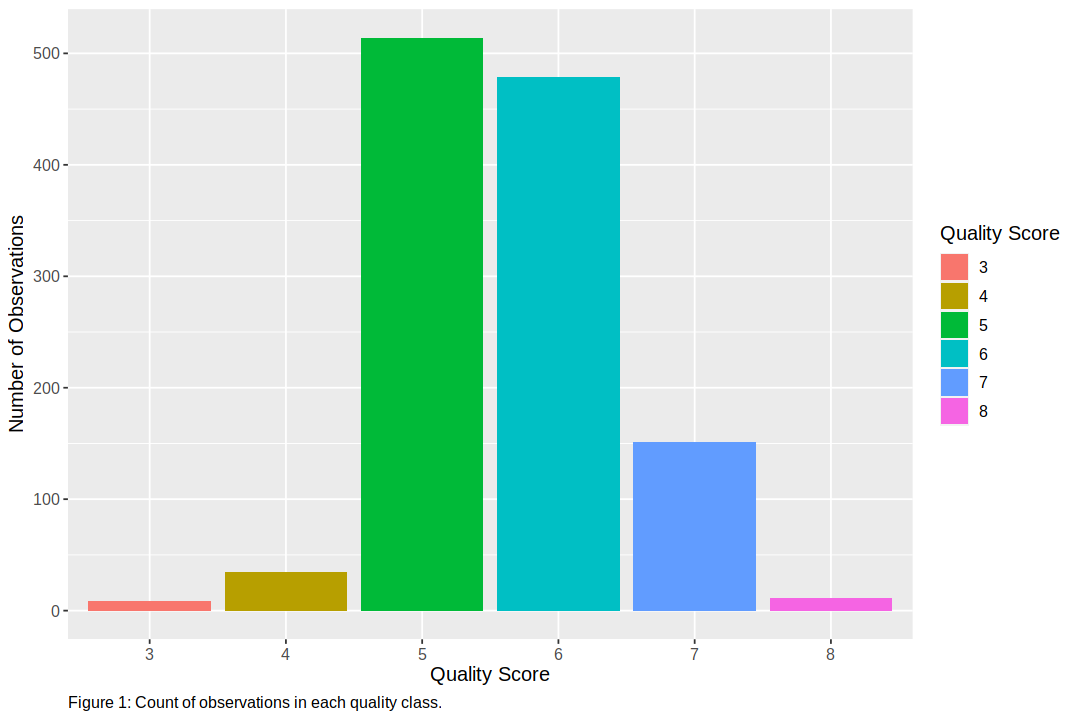

In [6]:
# Histogram to show wine quality distribution
options(repr.plot.width = 9, repr.plot.height = 6)
alcohol_plot <- ggplot(wine_train, aes(x = quality, fill = quality)) +
    geom_bar(stat = "count") +
    xlab("Quality Score") +
    ylab("Number of Observations") +
    labs(fill = "Quality Score", caption = "Figure 1: Count of observations in each quality class.") +
    theme(text = element_text(size = 12), plot.caption = element_text(hjust=0))
alcohol_plot

# The distribution is unbalanced and would cause a KNN algorithm to be biased. We can use oversampling to deal with this later on.

We wish to determine the ideal number of neighbors to most accurately classify wines with an unknown quality class. We begin by creating a model specification that specifies which package will be used to process the classification problem as well as the weight each neighbor's vote has on the classification. It is important to choose a good *K* value or else the classifier may be over/underfitted to our data. Therefore, we will use the `tune` function in the neighbors argument of the `nearest_neighbor` function to find the best *K* (the *K* value that predicts classes with the most accuracy).

A recipe is then created to standardize our data so as to avoid the final classifier being biased towards any one predictor. For example, volatile_acidity and free_sulfur_dioxide are on different scales but differences of the same magnitude in those predictor variables likely have different "weights" when it comes to evaluating wine quality. Thus, standardization is required. 

To choose the best *K*, we will be conducting cross-validation with the testing set and calculate the accuracy for each K value in a range (2-50). Due to computational power limitations, we are only performing a 5-fold validation.

In [20]:
# WITHOUT OVERSAMPLING 

# Using 5-fold cross validation we find the optimal parameter k to train the model with

# Create a model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a recipe that scales and centers the data
recipe_unbalanced <- recipe(quality ~ alcohol + free_sulfur_dioxide + volatile_acidity, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 5-fold cross validation
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

# k values to try
k_vals <- tibble(neighbors = seq(from = 2, to = 50, by = 1))

results_unbalanced <- workflow() |>
    add_recipe(recipe_unbalanced) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = k_vals) |>
    collect_metrics()
head(results_unbalanced)
h5('Table 3: Metrics collected from cross-verification')

! Fold3: internal:
  There were 49 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 48 ...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5846414,5,0.01597447,Preprocessor1_Model01
2,roc_auc,hand_till,0.6081704,5,0.01680113,Preprocessor1_Model01
3,accuracy,multiclass,0.5488392,5,0.01480743,Preprocessor1_Model02
3,roc_auc,hand_till,0.6399484,5,0.02502331,Preprocessor1_Model02
4,accuracy,multiclass,0.5454885,5,0.01225533,Preprocessor1_Model03
4,roc_auc,hand_till,0.6731064,5,0.02651091,Preprocessor1_Model03


Shiny tags cannot be represented in plain text (need html)

Using the accuracy of each *K* value from cross-verification (table 2), we can then plot the accuracy against *K*. We will use a line graph with dots at each *K* so that we can easily distinguish the *K* value at which the highest accuracy occurs. This can be accomplished by adding a `geom_point()` and a `geom_line()` layer to `ggplot`.

In [8]:
# Plot the accuracy for different k values
options(repr.plot.width = 12, repr.plot.height = 4)

accuracies_unbalanced <- results_unbalanced |> 
    filter(.metric == "accuracy")

accuracy_unbalanced_plot <- ggplot(accuracies_unbalanced, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure 2: Plot of estimated accuracy versus the number of neighbors (K).") +
    theme(text = element_text(size = 12), plot.caption = element_text(hjust=0)) +
    scale_x_continuous(breaks = seq(2, 50, by = 2)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0, 1)) # adjusting the y-axis

k_unbalanced <- accuracies_unbalanced |>
    arrange(-mean) |>
    slice(1)

k_unbalanced
h5('Table 4: Observation from cross-validation with highest accuracy.')

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5996046,5,0.01351892,Preprocessor1_Model01


Shiny tags cannot be represented in plain text (need html)

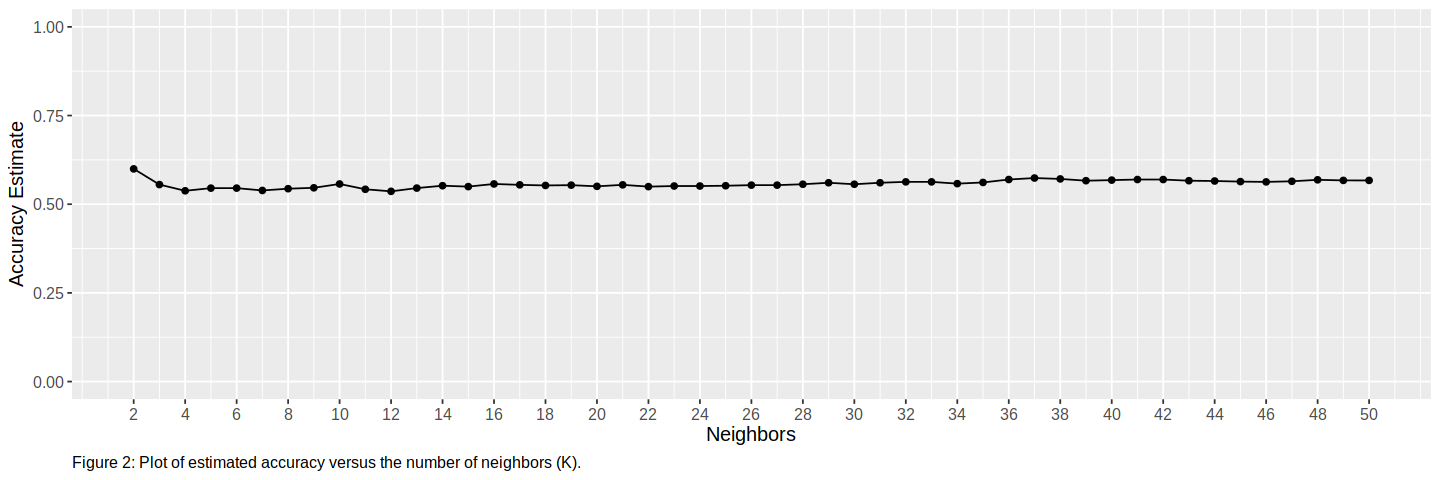

In [9]:
accuracy_unbalanced_plot

Arranging the accuracy data from our cross-validation from most to least accurate and slicing the first observation using `arrange` and `slice` respectively, reveals that *K*=2 provides the highest accuracy and that accuracy is relatively constant for any *K*>2. We will then adjust our model to use this *K* value. We may then assess the accuracy of our classifier's ability to predict each class by viewing its confusion matrix and the metrics from the model.

In [10]:
# Using the model on the test data by fitting it to the unbalanced training set with k = 2

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

wine_predictions_unbalanced <- workflow() |>
    add_recipe(recipe_unbalanced) |> # Unbalanced recipe
    add_model(knn_spec) |>
    fit(wine_train) |> # Fitting it to the unbalanced training data
    predict(wine_test) |>
    bind_cols(wine_test)

wine_metrics_unbalanced <- wine_predictions_unbalanced |>
    metrics(truth = quality, estimate = .pred_class)

confusion_unbalanced <- conf_mat(wine_predictions_unbalanced, truth = quality, estimate = .pred_class)

confusion_unbalanced
h5('Figure 3: Confusion matrix of our classifier using K=2')

          Truth
Prediction   3   4   5   6   7   8
         3   0   1   2   0   0   0
         4   0   2   8   1   1   1
         5   1   9 100  39   5   0
         6   0   6  45  98  12   3
         7   0   0  12  20  29   2
         8   0   0   0   1   1   1

Shiny tags cannot be represented in plain text (need html)

In [11]:
wine_metrics_unbalanced
h5('Table 5: Metrics of our classifier using K=2')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5750000
kap,multiclass,0.3519119


Shiny tags cannot be represented in plain text (need html)

To show the numbers of wines the classifier predicted was in each class compared to the actual wine quality in each quality from the testing set, we create a blue and red bar diagram. Before plotting, we want to rearrange the `wine_predictions_unbalanced` data frame. `pivot_longer` is used to combine .pre_class and quality into a single column which is named `score_type`, and all values of those two combined columns goes to a new created column named `score`. For the x-axis of the bar chart, we use `fill = score_type`, so those two different types of distribution can be differentiated by different colors.

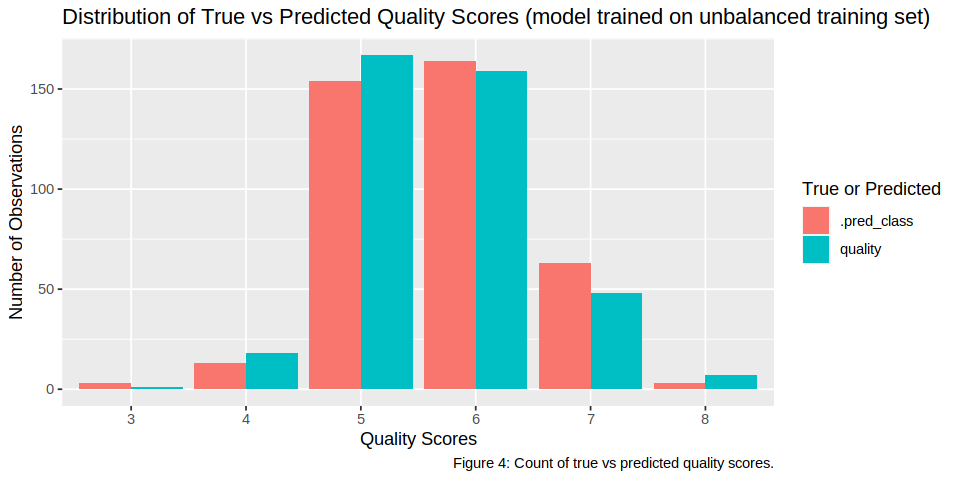

In [12]:
# Histogram to compare wine quality distribution vs the predicted distribution of the test set
options(repr.plot.width = 8, repr.plot.height = 4)
wine_plot_unbalanced <- wine_predictions_unbalanced |>
    pivot_longer(cols = c(".pred_class", "quality"), names_to = "score_type", values_to = "score") |>
    ggplot(aes(x = score, fill = score_type)) +
    geom_bar(stat = "count", position = "dodge") +
    xlab("Quality Scores") +
    ylab("Number of Observations") +
    labs(fill = "True or Predicted", caption = "Figure 4: Count of true vs predicted quality scores.") +
    ggtitle("Distribution of True vs Predicted Quality Scores (model trained on unbalanced training set)") +
    theme(plot.caption = element_text(hjust=0))

wine_plot_unbalanced

We find that the numbers of observation for quality scores for 3,4 and 8 aren't significant, and are unbalanced with other quality scores classes. This can affect the accuracy of our prediction. Using `upsample`, we are able to rebalance the data. This function helps us to duplicate the observation of quality scores 3, 4 and 8 for multiple times, so they can have more voting power in the later prediction. Then, we repeat what we have done before to standardize to our data and perform validation on it.

In [13]:
# WITH OVERSAMPLING 

# Balance the training data by oversampling the observations until all quality scores appear the same amount of times
set.seed(4321)
wine_train_balanced <- upsample(wine_train, "quality")

# Create a recipe that scales and centers the data and deals with the imbalance through oversampling
recipe_balanced <- recipe(quality ~ alcohol + free_sulfur_dioxide + volatile_acidity, data = wine_train_balanced) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 5-fold cross validation for balanced training data
wine_vfold_balanced <- vfold_cv(wine_train_balanced, v = 5, strata = quality)

# Use the same knn specification and k values as earlier
# Note that these results is based on some identical observations in both the training set and validation set due to upsampling
results_balanced <- workflow() |>
    add_recipe(recipe_balanced) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold_balanced, grid = k_vals) |>
    collect_metrics()

We want plot the accuracy for different K values, so we filter the `.metric` column with `accuracy` rows. Finally, we plot the k values from 2 to 50 to find the k with highest accuracy with the balanced data.

In [14]:
# Plot the accuracy for different k values
options(repr.plot.width = 12, repr.plot.height = 4)

accuracies_balanced <- results_balanced |> 
    filter(.metric == "accuracy")

accuracy_balanced_plot <- ggplot(accuracies_balanced, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",caption = "Figure 5: Plot of estimated accuracy versus the number of neighbors (K), now with oversampling.") +
    scale_x_continuous(breaks = seq(2, 50, by = 2)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0, 1)) + # adjusting the y-axis 
    theme(plot.caption = element_text(hjust=0))

k_balanced <- accuracies_balanced |>
    arrange(-mean) |>
    slice(1)

k_balanced
h5('Table 6: Observation from cross-validation with highest accuracy, now with oversampling.')

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.876772,5,0.003674368,Preprocessor1_Model01


Shiny tags cannot be represented in plain text (need html)

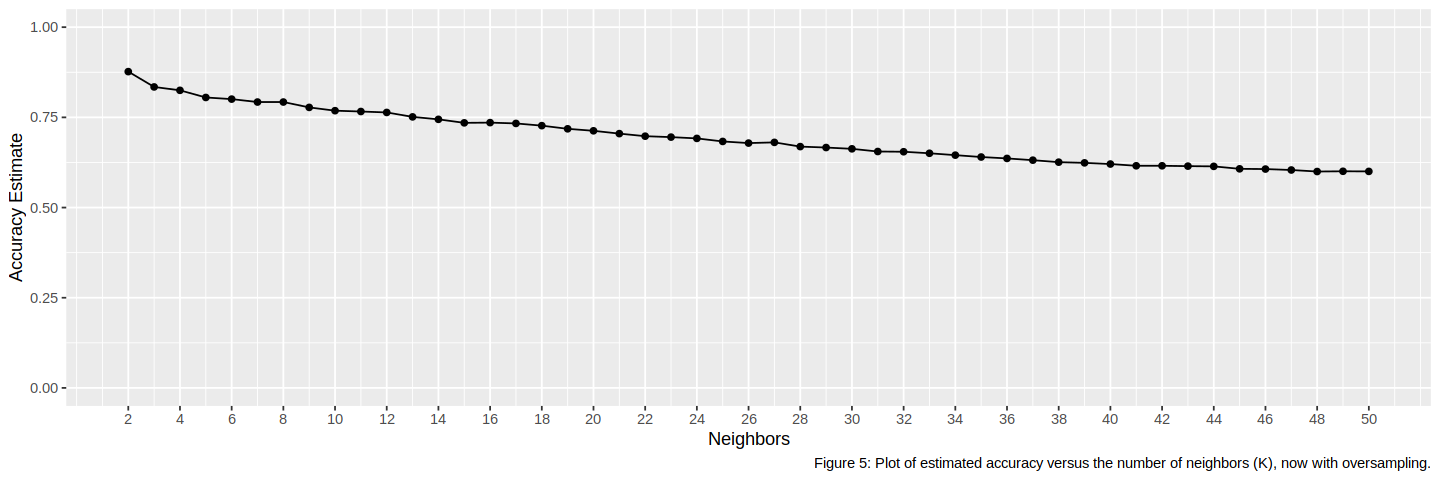

In [15]:
accuracy_balanced_plot

Figure 5 reveals that *K* = 2 provides the most accuracy and that accuracy is declining for any *K* > 2. We will continue to use *K* = 2 in our model which is the optimal K value. We may then assess the accuracy of our classifier's ability to predict each class by viewing its confusion matrix and the metrics from the model like before.

In [16]:
# Using the model on the test data by fitting it to the balanced training set with k = 2

wine_predictions_balanced <- workflow() |>
    add_recipe(recipe_balanced) |> # Balanced recipe
    add_model(knn_spec) |> # Same knn specification as earlier
    fit(wine_train_balanced) |> # Fitting it to the balanced training data
    predict(wine_test) |>
    bind_cols(wine_test)

wine_metrics_balanced <- wine_predictions_balanced |>
    metrics(truth = quality, estimate = .pred_class)

confusion_balanced <- conf_mat(wine_predictions_balanced, truth = quality, estimate = .pred_class)

confusion_balanced
h5('Figure 6: Confusion matrix of our classifier using K=2, now with oversampling')

          Truth
Prediction   3   4   5   6   7   8
         3   0   1   1   0   0   0
         4   0   1   8   0   1   1
         5   1   8 102  39   5   0
         6   0   8  44  98  13   3
         7   0   0  12  21  28   2
         8   0   0   0   1   1   1

Shiny tags cannot be represented in plain text (need html)

In [17]:
wine_metrics_balanced
h5('Table 7: Metrics of our classifier using K=2, now with oversampling')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5750000
kap,multiclass,0.3491328


Shiny tags cannot be represented in plain text (need html)

The accuracy with the balanced training set remains the same as the unbalanced training set : 57.5%. Like before, we will utilize a bar graph to compare the wine quality distribution and the predicted distribution of the training set.

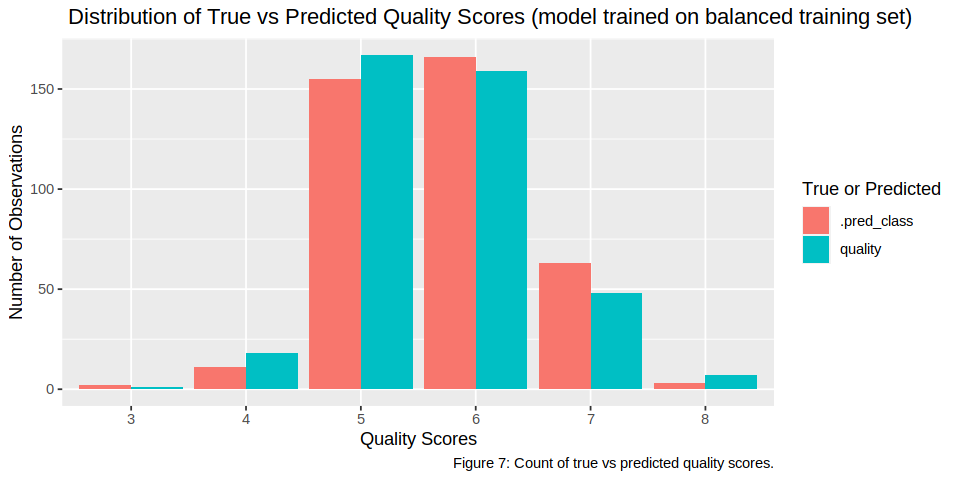

In [18]:
# Histogram to compare wine quality distribution vs the predicted distribution of the test set
options(repr.plot.width = 8, repr.plot.height = 4)
wine_plot_balanced <- wine_predictions_balanced |>
    pivot_longer(cols = c(".pred_class", "quality"), names_to = "score_type", values_to = "score") |>
    ggplot(aes(x = score, fill = score_type)) +
    geom_bar(stat = "count", position = "dodge") +
    xlab("Quality Scores") +
    ylab("Number of Observations") +
    labs(fill = "True or Predicted", caption = "Figure 7: Count of true vs predicted quality scores.") +
    ggtitle(" Distribution of True vs Predicted Quality Scores (model trained on balanced training set)") +
    theme(plot.caption = element_text(hjust=0))

wine_plot_balanced

Upon inspecting the bar graph shown above, we find that the number of observations for quality scores of 3, 4 and 8 are insignificant similar to the unbalanced data set. The imbalance between the quality scores 5, 6 and 7 are quite apparent in comparison and seems to indicate a flaw in our model. Using the balanced training set with upsampled data seems to yield the same results which renders the model unreliable for quality prediction.

### Expected outcomes and significance:
Our model is capable of predicting wine quality for wines within the test set with a 57.5% accuracy. While this is better than guessing (in which case there is 10% chance of getting it right), it is far from ideal. This potentially indicates that the predictor variables (volatile acidity, free sulfur dioxide value, alcohol content) we have chosen are not significantly related to wine quality. However, a more plausible explanation is that our model is flawed.

The "optimal" *K* we found was *K* = 2. However, this *K* obviously was not adequate for accurately predicting wine quality. We decided that our model is affected by class imbalance. In our training set, wines of quality class 5 and 6 each taking up over 42.87% and 39.95% of the training set, respectively. If there is an excess of these labels, then the algorithm is more likely to predict 5 and 6 in general since it is most likely to be correct, even if the pattern of the data suggests the new data point belongs to a rarer label (such as 3 or 8). We tried to address this issue by up-sampling our data so that rarer classes hold more voting power. However, rare classes (e.g. 3) are too few in number to be oversampled and used in cross-validation. The `upsample` function will duplicate rarer classes so that the number of their instances are equal to that of the more frequent classes. This results in the all observations of some rare quality classes like 3 to be duplicated. The validation set and the sub-training set during cross-validation would then have significant overlap in their data for the rarer quality classes. This results in the appearance of a higher accuracy (as seen in table ?) but in reality, the validation sets are validating on the same data as the sub-training sets; the model is essentially cheating during cross-validation since it was trained on the same data that is present in the validation set. This still resulted in a *K* value of 2, but with a higher accuracy due to the aforementioned cheating when predicting the rarer classes. Oversampling did not, in fact, improve our classifiers accuracy when tested on the testing set.

We expect to accurately predict the quality of wine based on the volatile acidity, free sulfur dioxide value, and alcohol content of the wine. We were not able to accomplish this. However, if the algorithm could be further improved, it could help winemakers understand the qualities they should prioritize or selectively specialize in to increase the quality of their wine. Similarly, the classification algorithm could help an avid oenophiles/consumers make more informed decisions when purchasing expensive Wine. The data we plan on using is based in Portugal. Further questions such as the difference in the importance of different traits in the classification of wine quality in other parts of the world could provide useful information and lead to new relationships. A more specific question could be whether the species/region where the grapes used to make the wine are foraged lead to differences in quality.

